# Monitors and Inputs

@[Chaoming Wang](mailto:adaduo@outlook.com)

BrainPy has a [systematic naming system](../tutorial_math/base.ipynb). Any model in BrainPy have a unique name. Nodes, integrators, and variables can be easily accessed in a huge network. Based on this naming system, BrainPy provide the convenient monitoring and input supports. In this section, we are going to talk about this. 

In [1]:
import brainpy as bp
import brainpy.math as bm

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Monitors

In BrainPy, any instance of ``brainpy.DynamicalSystem`` has the inherent monitor. Users can set up the monitor when initializing the brain objects. For example, if you have the following `HH` neuron model,

In [3]:
class HH(bp.NeuGroup):
  def __init__(self, size, ENa=50., EK=-77., EL=-54.387, C=1.0, 
               gNa=120., gK=36., gL=0.03, V_th=20., **kwargs):
    super(HH, self).__init__(size=size, **kwargs)

    # parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.C = C
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.V_th = V_th

    # variables
    self.V = bm.Variable(bm.ones(self.num) * -65.)
    self.m = bm.Variable(bm.ones(self.num) * 0.5)
    self.h = bm.Variable(bm.ones(self.num) * 0.6)
    self.n = bm.Variable(bm.ones(self.num) * 0.32)
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    
    # functions
    self.integral = bp.odeint(self.derivative, method='exponential_euler')

  def derivative(self, V, m, h, n, t, Iext):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (self.gNa * m ** 3 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

    return dVdt, dmdt, dhdt, dndt

  def update(self, _t, _dt):
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input)
    self.spike[:] = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.V[:] = V
    self.m[:] = m
    self.h[:] = h
    self.n[:] = n
    self.input[:] = 0

The monitor can be set up when users create a `HH` neuron group. 

First method is to a list/tuple of strings to initialize a monitor. 

In [4]:
group1 = HH(size=10, monitors=['V', 'spike'])

type(group1.mon)

brainpy.simulation.monitor.Monitor

Users can directly use Monitor class to initialize a monitor. 

In [5]:
# set up a monitor using 
group2 = HH(size=10, monitors=bp.Monitor(variables=['V', 'spike']))

Once we run the given model, these monitors will automatically record the variable evolutions in the corresponding models. Users can access these variable trajectories by using ``(model_name).mon.(variable_name)``. The history time ``(model_name).mon.ts`` will also be generated after the model finishes its running. Let's see an example. 

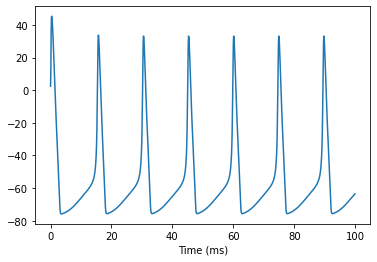

In [6]:
group1.run(100., inputs=('input', 10))

bp.visualize.line_plot(group1.mon.ts, group1.mon.V, show=True)

### The mechanism of ``monitors``

We try to record ``HH.V`` and ``HH.spike``, why we define ``monitors=['V', 'spike']`` during ``HH`` initialization is successful? How does ``brainpy.Monitor`` recognize what variables I want to trace?

Actually, given the monitor target keys, BrainPy, first of all, check whether this key is the attribute of the node which defines this monitor key. For monitor targets ``'V'`` and ``'spike'``, it is really the attributes of ``HH`` model. However, if not, BrainPy first check whether the key's host (`brainpy.DynamicalSystem` class object) can be accessible in ``.nodes()``, then check whether the host has the specified variable. For example, we define a network, and monitor the variable by the absolute path. 

In [7]:
net = bp.Network(HH(size=10, name='X'), 
                 HH(size=20, name='Y'), 
                 HH(size=30), 
                 monitors=['X.V', 'Y.spike'])

net.build_monitors()  # it's ok

In [8]:
z = HH(size=30, name='Z')
net = bp.Network(HH(size=10), HH(size=20), monitors=['Z.V'])

# node "Z" can not be accessed in 'net.nodes()'
try:
    net.build_monitors()
except Exception as e:
    print(type(e).__name__, e)

BrainPyError Cannot find target Z.V in monitor of <brainpy.simulation.brainobjects.network.Network object at 0x7f20b03b3040>, please check.


**Note 1**

BrainPy only supports to monitor Variable. This is because BrainPy assumes only monitoring [Variable](../tutorial_math/variables.ipynb)'s trajectory is meaningful, because they are dynamically changed. 

In [9]:
try:
    HH(size=1, monitors=['gNa']).build_monitors()
except Exception as e:
    print(type(e).__name__, e)

BrainPyError "gNa" in <__main__.HH object at 0x7f2080275bb0> is not a dynamically changed Variable, its value will not change, we cannot monitor its trajectory.


**Note 2**

The monitors in BrainPy only record the flattened tensor values. This means if your target variable is a matrix with the shape of ``(N, M)``, the resulting trajectory value in the monitor after running ``T`` times will be tensor with the shape of ``(T, N x M)``.

In [10]:
class MatrixVarModel(bp.DynamicalSystem):
    def __init__(self, **kwargs):
        super(MatrixVarModel, self).__init__(**kwargs)
        
        self.a = bm.Variable(bm.zeros((4, 4)))
    
    def update(self, _t, _dt):
        self.a += 0.01
        

duration = 10
model = MatrixVarModel(monitors=['a'])
model.run(duration)

print(f'The expected shape of "model.mon.a" is: {(int(duration/bm.get_dt()), model.a.size)}')
print(f'The actual shape of "model.mon.a" is: {model.mon.a.shape}')

The expected shape of "model.mon.a" is: ((100, 16))
The actual shape of "model.mon.a" is: (100, 16)


### Monitor variables at the selected index

Sometimes, we do not always take care of the all the content in a variable. We may be only interested in the values at the selected index. Moreover, for huge networks with a long time simulation, monitors will be a big part to consume RAM. So, only monitoring variables at the selected index will be a good solution. Fortunately, BrainPy supports we monitor parts of elements in a Variable with the format of tuple/dict like this:

In [11]:
group3 = HH(
    size=10,
    monitors=[
       'V',  # monitor all values of Variable 'V' 
      ('spike', [1, 2, 3]), # monitor values of Variable at index of [1, 2, 3]
    ]
)

group3.run(100., inputs=('input', 10.))

print(f'The monitor shape of "V" is (run length, variable size) = {group3.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {group3.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (1000, 10)
The monitor shape of "spike" is (run length, index size) = (1000, 3)


Or, we can use a dictionary to specify the interested index of the variable:

In [12]:
group4 = HH(
  size=10,
  monitors={'V': None,  # 'None' means all values will be monitored
            'spike': [1, 2, 3]}  # specify the interested index 
)

group4.run(100., inputs=('input', 10.))

print(f'The monitor shape of "V" is (run length, variable size) = {group4.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {group4.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (1000, 10)
The monitor shape of "spike" is (run length, index size) = (1000, 3)


Also, we can directly instantiate `brainpy.Monitor` class:

In [13]:
group5 = HH(
  size=10,
  monitors=bp.Monitor(variables=['V', ('spike', [1, 2, 3])])
)
group5.run(100., inputs=('input', 10.))

print(f'The monitor shape of "V" is (run length, variable size) = {group5.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {group5.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (1000, 10)
The monitor shape of "spike" is (run length, index size) = (1000, 3)


In [14]:
group6 = HH(
  size=10,
  monitors=bp.Monitor(variables={'V': None, 'spike': [1, 2, 3]})
)
group6.run(100., inputs=('input', 10.))

print(f'The monitor shape of "V" is (run length, variable size) = {group5.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {group5.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (1000, 10)
The monitor shape of "spike" is (run length, index size) = (1000, 3)


**Note**

When users want to record a small part of a variable whose dimension > 1,  due to ``brainpy.Monitor`` records a flattened tensor variable, they must provide the index positions at the flattened tensor.  

### Monitor variables with a customized period

In a long simulation with small `dt` time step, what we take care about is the trend of the variable evolution, not the exact values at each time point (especially when `dt` is very small). For this scenario, we can initializing the monitors with the `intervals` item specification:

In [15]:
group7 = HH(
  size=10,
  monitors=bp.Monitor(variables={'V': None, 'spike': [1, 2, 3]},
                      intervals={'V': None, 'spike': 1.})  # in 1 ms, we record 'spike' only once
)

# The above instantiation is equivalent to:
# 
# group7 = HH(
#   size=10, monitors=bp.Monitor(variables=['V', ('spike', [1, 2, 3])],
#                                intervals=[None, 1.])
# )

In this example, we monitor "spike" variables at the index of [1, 2, 3] for each `1 ms`. 

In [16]:
group7.run(100., inputs=('input', 10.))

print(f'The monitor shape of "V" = {group7.mon.V.shape}')
print(f'The monitor shape of "spike" = {group7.mon.spike.shape}')

The monitor shape of "V" = (1000, 10)
The monitor shape of "spike" = (99, 3)


It's worthy to note that for the monitor variable `(variable_name)` with a non-none ``intervals`` specification, a corresponding time item `(variable_name).t` will be generated in the monitor. This is because its time will be different from the default time trajectory. 

In [17]:
print('The shape of ["spike"]: ', group7.mon['spike'].shape)
print('The shape of ["spike.t"]: ', group7.mon['spike.t'].shape)

print('group7.mon["spike.t"]: ', group7.mon["spike.t"])

The shape of ["spike"]:  (99, 3)
The shape of ["spike.t"]:  (99,)
group7.mon["spike.t"]:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90.
 91. 92. 93. 94. 95. 96. 97. 98. 99.]


## Inputs

BrainPy also provides `inputs` operation for each instance of ``brainpy.DynamicalSystem``. It should be carried out during calling the ``.run(..., inputs=xxx)`` function. 

The aim of ``inputs`` is to mimic the input operations in experiments like Transcranial Magnetic Stimulation (TMS) and patch clamp recording. ``inputs`` should have the format like ``(target, value, [type, operation])``, where 

- ``target`` is the target variable to give the input. 
- ``value`` is the input value. It can be a scalar, a tensor, or a iterable function. 
- ``type`` is the type of the input value. It support two types of input: ``fix`` and ``iter``. 
- ``operation`` is the input operation on the target variable. It should be set as one of `{ + , - , * , / , = }`, and if users do not provide this item explicitly, it will be set to '+' by default, which means that the target variable will be updated as ``val = val + input``. 

You can give multiple inputs for different target variables, like:

```python

inputs=[(target1, value1, [type1, op1]),  
        (target2, value2, [type2, op2]),
              ... ]
```

### The mechanism of ``inputs``

The mechanism of ``inputs`` is the same with ``monitors`` (see [The mechanism of ``monitors``](#The-mechanism-of-monitors)). BrainPy first check whether user specified ``target`` can be accessed by the relative path. 

If not, BrainPy separate the host name and the variable name, and further check whether the host name is defined in the ``.node()`` and whether the variable name can be accessed by the retrieved host. Therefore, in a *input* setting, the ``target`` can be set with the absolute or relative path. For example, in the below network model,

In [46]:
class Model(bp.DynamicalSystem):
    def __init__(self, num_sizes, **kwargs):
        super(Model, self).__init__(**kwargs)
        
        self.l1 = HH(num_sizes[0], name='L')
        self.l2 = HH(num_sizes[1])
        self.l3 = HH(num_sizes[2])
        
    def update(self, _t, _dt):
        self.l1.update(_t, _dt)
        self.l2.update(_t, _dt)
        self.l3.update(_t, _dt)

In [47]:
model = Model([10, 20, 30])

model.run(100, inputs=[('L.V', 2.0),  # access with the absolute path
                       ('l2.V', 1),  # access with the relative path
                       ])

0.7869570255279541

``inputs`` supports two types of data: ``fix`` and ``iter``. The first one means that the data is static; the second one denotes the data can be iterable, no matter the input value is a tensor or a function. 'iter' type must be explicitly stated. 

In [49]:
# a tensor

model.run(100, inputs=('L.V', bm.ones(1000) * 2., 'iter'))

0.8278141021728516

In [51]:
# a function

def current():
    while True: yield 2.

model.run(100, inputs=('L.V', current(), 'iter'))

0.7979824542999268

### Current construction functions 

BrainPy provides several convenient input functions to help users construct input currents. 

#### ``section_input()``

[brainpy.inputs.section_input()](../apis/simulation/generated/brainpy.simulation.inputs.section_input.rst) is an updated function of previous `brainpy.inputs.constant_input()` (see below). 

Sometimes, we need input currents with different values in different periods. For example, if you want to get an input in which 0-100 ms is zero, 100-400 ms is value 1., and 400-500 ms is zero, then, you can define:

In [39]:
current, duration = bp.inputs.section_input(values=[0, 1., 0.],
                                            durations=[100, 300, 100],
                                            return_length=True)

In [40]:
def show(current, duration, title):
    ts = np.arange(0, duration, 0.1)
    plt.plot(ts, current)
    plt.title(title)
    plt.xlabel('Time [ms]')
    plt.ylabel('Current Value')
    plt.show()

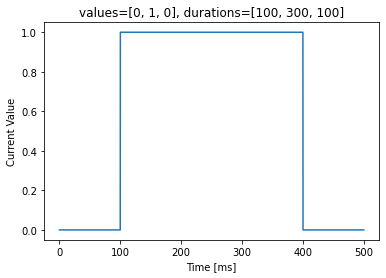

In [41]:
show(current, duration, 'values=[0, 1, 0], durations=[100, 300, 100]')

#### ``constant_input()``

[brainpy.inputs.constant_input()](../apis/simulation/generated/brainpy.simulation.inputs.constant_input.rst) function helps you to format constant currents in several periods.

For the input created above, we can define it again with `constant_input()` by:

In [21]:
current, duration = bp.inputs.constant_input([(0, 100), (1, 300), (0, 100)])

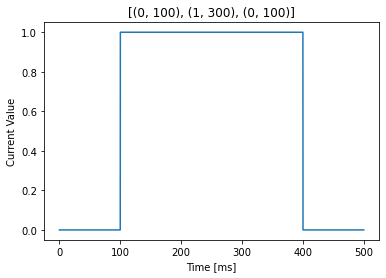

In [22]:
show(current, duration, '[(0, 100), (1, 300), (0, 100)]')

Another example is this:

In [23]:
current, duration = bp.inputs.constant_input([(-1, 10), (1, 3), (3, 30), (-0.5, 10)], dt=0.1)

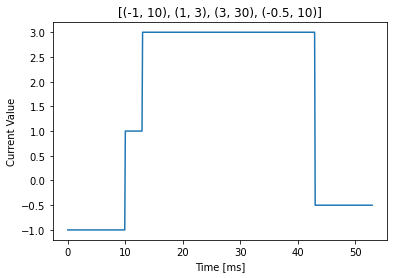

In [24]:
show(current, duration, '[(-1, 10), (1, 3), (3, 30), (-0.5, 10)]')

#### ``spike_input()``

[brainpy.inputs.spike_input()](../apis/simulation/generated/brainpy.simulation.inputs.spike_input.rst) helps you to construct an input like a series of short-time spikes. It receives the following settings:

- `sp_times` :  The spike time-points. Must be an iterable object. For example, list, tuple, or arrays.
- `sp_lens` : The length of each point-current, mimicking the spike durations. It can be a scalar float to specify the unified duration. Or, it can be list/tuple/array of time lengths with the length same with `points`. 
- `sp_sizes` : The current sizes. It can be a scalar value. Or, it can be a list/tuple/array of spike current sizes with the length same with `points`.
- `duration` : The total current duration.
- `dt` : The time step precision. The default is None (will be initialized as the default `dt` step). 

For example, if you want to generate a spike train at 10 ms, 20 ms, 30 ms, 200 ms, 300 ms,
    and each spike lasts 1 ms and the spike current is 0.5, then you can use the
    following funtions:

In [42]:
current = bp.inputs.spike_input(
    sp_times=[10, 20, 30, 200, 300],
    sp_lens=1.,  # can be a list to specify the spike length at each point
    sp_sizes=0.5,  # can be a list to specify the spike current size at each point
    duration=400.)

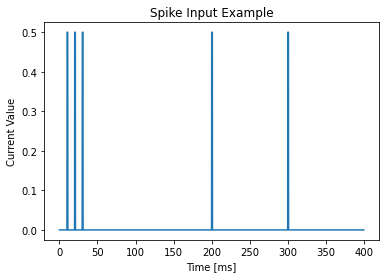

In [43]:
show(current, 400, 'Spike Input Example')

#### ``ramp_input()``

[brainpy.inputs.ramp_input()](../apis/simulation/generated/brainpy.simulation.inputs.ramp_input.rst) mimics a ramp or a step current to the input of the circuit. It receives the following settings:

- `c_start` : The minimum (or maximum) current size.
- `c_end` : The maximum (or minimum) current size.
- `duration` : The total duration.
- `t_start` : The ramped current start time-point.
- `t_end` : The ramped current end time-point. Default is the None.
- `dt` : The current precision.

We illustrate the usage of `brainpy.inputs.ramp_input()` by two examples.

In the first example, we increase the current size from 0. to 1. between the start time (0 ms) and the end time (1000 ms). 

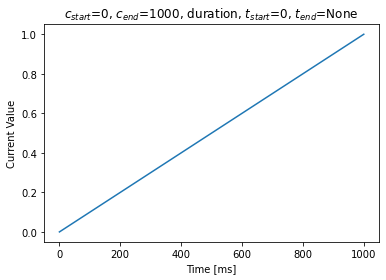

In [44]:
duration = 1000
current = bp.inputs.ramp_input(0, 1, duration)

show(current, duration, r'$c_{start}$=0, $c_{end}$=%d, duration, '
                        r'$t_{start}$=0, $t_{end}$=None' % (duration))

In the second example, we increase the current size from 0. to 1. from the 200 ms to 800 ms.

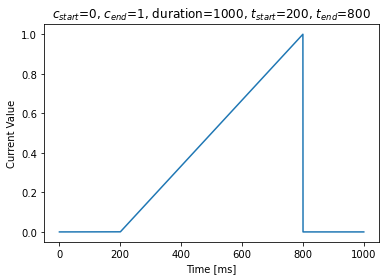

In [45]:
duration, t_start, t_end = 1000, 200, 800
current = bp.inputs.ramp_input(0, 1, duration, t_start, t_end)

show(current, duration, r'$c_{start}$=0, $c_{end}$=1, duration=%d, '
                        r'$t_{start}$=%d, $t_{end}$=%d' % (duration, t_start, t_end))

#### General property

There are several general properties for input construction functions. 

**Property 1**: All input functions can automatically broadcast the current shapes, if they are heterogenous among different periods. For example, during period 1 we give an input with a scalar value, during period 2 we give an input with a vector shape, and during period 3 we give a matrix input value. Input functions will broadcast them to the maximum shape. For example, 

In [32]:
current = bp.inputs.section_input(values=[0, bm.ones(10), bm.random.random((3, 10))],
                                  durations=[100, 300, 100])

current.shape

(5000, 3, 10)

**Property 2**: Every input function receives a ``dt`` specification. If ``dt`` is not provided, input functions will use the default ``dt`` in the whole BrainPy system. 

In [33]:
bp.inputs.section_input(values=[0, 1, 2], durations=[10, 20, 30], dt=0.02).shape

(3000,)

In [34]:
bp.inputs.section_input(values=[0, 1, 2], durations=[10, 20, 30], dt=0.2).shape

(300,)

In [35]:
# the default 'dt' in 0.1

bp.inputs.section_input(values=[0, 1, 2], durations=[10, 20, 30]).shape

(600,)